<center style="font-size: 32px; font-weight: bold; ">
                       RNN: Прогнозирование следующей буквы
</center>



Описание: <a href="http://qudata.com/ml/ru/NN_RNN_Torch.html">NN_RNN_Torch.html</a>,

# Библиотеки

In [1]:
import torch
import torch.nn as nn

#import ctypes
#ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

# Загружаем текст

In [2]:
import re, zipfile, numpy as np, time
from   time import perf_counter as tm                  # таймер sec

CHARS  = " .абвгдежзийклмнопрстуфхцчшщъыьэюя\n"        # алфавит
charID = { c:i for i,c in enumerate(CHARS) }           # буква в номер

def preprocess(txt):
    """ Буквы не из алфавита заменяем пробелами """
    txt = txt.lower().replace('ё','e')
    txt = txt.lower().replace('?','.')
    txt = ''.join( [c if c in CHARS else ' ' for c in txt] )    
    txt = re.sub(' +', ' ', txt).replace(' .', '.')
    return  re.sub('\n\s+', '\n', txt)

def load_Sultan():
    with open("C:/!/Python/Data/NLP/saltan.txt", "r", encoding='utf-8-sig') as file:
        return preprocess ( file.read() )
    
def load_Books():
    txt = ""
    with zipfile.ZipFile("C:/!/Data/nlp/books/books.zip") as myzip:
        for fname in myzip.namelist():
            print(fname, end=": ")
            with myzip.open(fname) as myfile:
                st = preprocess ( myfile.read().decode("utf-8") )                
                print(len(st.split()), "words")  
                txt += st
    return txt
    
#text = load_Sultan()        
text = load_Books()        
        
print(f"chars: {len(CHARS)}")            
print(f"|{text[:100]}|")        
print(f"|{text[-100:]}|")    
print(len(text))

Akunin_Priklyucheniya-Erasta-Fandorina_1_Azazel.txt: 53879 words
Akunin_Provincialnyy-detektiv_1_Pelagiya-i-belyy-buldog.txt: 68067 words
Akunin_Zhanry_2_Shpionskiy-roman.txt: 63546 words
Strugackiy_Maksim-Kammerer_1_Obitaemyy-ostrov.txt: 96243 words
Strugackiy_Maksim-Kammerer_2_Zhuk-v-muraveynike.txt: 53396 words
Strugackiy_Maksim-Kammerer_3_Volny-gasyat-veter.txt: 41175 words
Strugackiy_Ponedelnik-nachinaetsya-v-subbotu.txt: 60048 words
Strugackiy_Ulitka-na-sklone.txt: 60777 words
Tolstoy_Voyna-i-mir-Tom-1.txt: 104440 words
Tolstoy_Voyna-i-mir-Tom-2.txt: 116938 words
Tolstoy_Voyna-i-mir-Tom-3.txt: 127024 words
Tolstoy_Voyna-i-mir-Tom-4.txt: 104756 words
Vasilev_Akula-pera-v-Mire-Fayrolla_1_Igra-ne-radi-igry.txt: 81571 words
Vasilev_A-Smolin-vedmak_1_Chuzhaya-sila.txt: 109389 words
Vasilev_Kovcheg-5-0_1_Mesto-pod-solncem.txt: 131243 words
Vasilev_Ucheniki-Vorona_1_Zamok-na-Voroney-gore.txt: 97007 words
chars: 35
|борис акунин
азазель
глава первая 
в которой описывается некая циничная 

# Параметры

In [3]:
LENGTH, STEP, NUM, = 25, 25, 20
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 250, 1, 0

# Готовим данные

In [4]:
%%time

textID = [ charID[c] for c in text ]

num_seq  = int((len(textID)-LENGTH)/STEP)-1   # число последовательностей

X_dat = torch.empty (num_seq, LENGTH, dtype=torch.long)
Y_dat = torch.empty (num_seq, LENGTH, dtype=torch.long)

for i in range(num_seq):        
    X_dat[i] = torch.tensor(textID[i*STEP:   i*STEP+LENGTH],   dtype=torch.long)
    Y_dat[i] = torch.tensor(textID[i*STEP+1: i*STEP+LENGTH+1], dtype=torch.long)
    
idx = torch.randperm( len(X_dat) )     # перемешанный список индексов
X_dat = X_dat[idx]
Y_dat = Y_dat[idx]

num_trn = int(0.75*len(X_dat))
X_trn, Y_trn = X_dat[:num_trn], Y_dat[:num_trn]
X_val, Y_val = X_dat[num_trn:], Y_dat[num_trn:]

print("trn:", X_trn.shape, Y_trn.shape, X_trn.max(), Y_trn.max())        
print("val:", X_val.shape, Y_val.shape, X_val.max(), Y_val.max())        
        
def tensor2st(t):
    return ''.join( [ CHARS[i] for i in t])

print(f"len(textID):{len(textID)} num:{num_seq}, STEP:{STEP}")
print(X_trn.shape, Y_trn.shape, X_trn.max(), Y_trn.max())        
print(textID[:100])
print(tensor2st(X_trn[0]))
print(tensor2st(Y_trn[0]))

trn: torch.Size([254037, 25]) torch.Size([254037, 25]) tensor(34) tensor(34)
val: torch.Size([84679, 25]) torch.Size([84679, 25]) tensor(34) tensor(34)
len(textID):8467974 num:338716, STEP:25
torch.Size([254037, 25]) torch.Size([254037, 25]) tensor(34) tensor(34)
[3, 16, 18, 10, 19, 0, 2, 12, 21, 15, 10, 15, 34, 2, 9, 2, 9, 7, 13, 30, 34, 5, 13, 2, 4, 2, 0, 17, 7, 18, 4, 2, 33, 0, 34, 4, 0, 12, 16, 20, 16, 18, 16, 11, 0, 16, 17, 10, 19, 29, 4, 2, 7, 20, 19, 33, 0, 15, 7, 12, 2, 33, 0, 24, 10, 15, 10, 25, 15, 2, 33, 0, 4, 29, 23, 16, 6, 12, 2, 34, 4, 0, 17, 16, 15, 7, 6, 7, 13, 30, 15, 10, 12, 0, 14, 2, 33, 0, 5, 16]
то человек бывший для мен
о человек бывший для меня
Wall time: 11.9 s


# Модель

Для экономи памяти и ускорения, модель внутри функции forward вычисляет ошибку

In [5]:
class RNN(nn.Module):
    def __init__(self, E, H, LAYERS=1):           
        super(RNN, self).__init__()      
        self.H    = H
        self.mode = 1
        self.rnn  = nn.GRU(E, H, num_layers=LAYERS)
        
    def forward(self, x, h0=None):              # (L,B,E), (1,B,H)         
        if self.mode == 1: return self.forward1( x, h0 )
        if self.mode == 2: return self.forward2( x, h0 )              
        if self.mode == 3: return self.forward3( x, h0 )              
        
    def forward1(self, x, h0=None):             # (L,B,E), (LAYERS,B,H) 
        return self.rnn(x, h0)                  # (L,B,H), (LAYERS,B,H)  
    
    def forward2(self, x, h0=None):
        (L, B, E), H =  x.size(), self.H        

        self.h =  [ torch.zeros(1,B,H, device = x.device) if h0 is None else h0 ]         
        for i in range(L):                       # по всем ячейкам
            _, h = self.rnn( x[i].view(1,B,E), self.h[i] )        
            self.h.append( h.clone() )           # запоминем скрытые состояния
                
        for h in self.h: h.retain_grad()         # будут помнить свои градиенты                

        self.y = torch.cat(self.h[1:], dim=0)    # (L,B,H) объединяем все выходы
        self.y.retain_grad()                     # будут помнить свои градиенты                 
         
        return self.y, self.h[-1]                # (L,B,H), (1,B,H)  

    def forward3(self, x, h0=None):
        (L, B, E), H =  x.size(), self.H        

        self.h =  [ torch.zeros(1,B,H, device = x.device) if h0 is None else h0 ]         
        for i in range(L):                       # по всем ячейкам
            y, h = self.rnn( x[i].view(1,B,E), self.h[i] )        
            self.h.append( h.clone() )           # запоминем скрытые состояния
            self.y = y if i==0 else torch.cat([self.y, y],  dim=0)
                
        for h in self.h: h.retain_grad()         # будут помнить свои градиенты                

        self.y.retain_grad()                     # будут помнить свои градиенты                          
        return self.y, self.h[-1]                # (L,B,H), (1,B,H)  
    
    
    def stat(self):     
        if self.mode == 1:
            return
        self.V_h, self.G_h = torch.zeros(len(self.h)), torch.zeros(len(self.h))
        for i,h in enumerate(self.h):            
            self.G_h[i] = 0 if h.grad is None else ((h.grad**2).mean())**0.5        
            self.V_h[i] = ((h.detach()**2).mean())**0.5            
        self.G_y = ((self.y.grad**2).mean(dim=(1,2)))**0.5            

class Model(nn.Module):
    def __init__(self, C, E, H, LAYERS = 1, DROP=0, EMBED=True):   
        """число классов, размерности эмбединга и скрытого состояния, слоёв""" 
        super(Model, self).__init__()    
        print(f"C:{C}, E:{E}, H:{H}, LAYERS:{LAYERS}")
        self.C = C 
        self.EMBED = EMBED
        
        if EMBED:
            self.emb  = nn.Embedding(C, E, scale_grad_by_freq=True)        
        self.rnn  = RNN(E,H,LAYERS) 
        self.fc   = nn.Linear(H, C) 
        self.drop = nn.Dropout(DROP)
                
    def forward(self, x, h0=None, NUM=1):       # (B,L), (1,B,H)    
        if self.EMBED:
            x      = self.emb ( x.t()  )            # (L,B,E)     
        else:
            x = torch.zeros(len(x), x.size(1), self.C).scatter_(2, x.unsqueeze(2),  1.) # (B,L,C)
            x = x.transpose(0,1).contiguous()

        yr, hr = self.rnn ( x, h0 )             # (L,B,H),  (1,B,H)            
        
        y = yr[-NUM : ]                         # (NUM,B,H) последние выходы  
        y = self.drop(y)
        y = self.fc(y)                          # (NUM,B,C)                   
        return y.permute(1,2,0), hr             # (B,C,NUM), (LAYERS,B,H)  
        
model = Model(len(CHARS), E_DIM, H_DIM, NUM_LAYERS, EMBED=True)  # экземпляр сети

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

model.to(gpu)

y, h_rnn = model( x  = torch.zeros(5, LENGTH, dtype=torch.long).to(gpu), NUM=2  )
print(y.shape, h_rnn.shape)

losses = []                                      # история ошибок для графика

C:35, E:10, H:250, LAYERS:1
torch.Size([5, 35, 2]) torch.Size([1, 5, 250])


In [6]:
tot = 0
for k, v in model.state_dict().items():
    pars = torch.tensor(list(v.shape)).prod(); tot += pars
    print(f'{k:20s} :{pars:7d}  shape: {tuple(v.shape)} ')
print(f"{'total':20s} :{tot:7d}")

emb.weight           :    350  shape: (35, 10) 
rnn.rnn.weight_ih_l0 :   7500  shape: (750, 10) 
rnn.rnn.weight_hh_l0 : 187500  shape: (750, 250) 
rnn.rnn.bias_ih_l0   :    750  shape: (750,) 
rnn.rnn.bias_hh_l0   :    750  shape: (750,) 
fc.weight            :   8750  shape: (35, 250) 
fc.bias              :     35  shape: (35,) 
total                : 205635


# Веса

In [7]:
%%time
weight = torch.ones(len(CHARS), dtype=torch.float)
for c in textID:
    weight[c] += 1
weight /= len(text)

weight = -weight.log_()
print ( [f'{c}:{weight[i]:.2f}' for i,c in enumerate(CHARS)] )
weight /= weight.sum()
print(weight.sum())

[' :1.85', '.:4.26', 'а:2.70', 'б:4.27', 'в:3.32', 'г:4.20', 'д:3.67', 'е:2.67', 'ж:4.80', 'з:4.26', 'и:2.91', 'й:4.69', 'к:3.56', 'л:3.22', 'м:3.65', 'н:2.91', 'о:2.37', 'п:3.77', 'р:3.31', 'с:3.14', 'т:2.98', 'у:3.75', 'ф:6.42', 'х:4.98', 'ц:5.82', 'ч:4.39', 'ш:4.96', 'щ:5.86', 'ъ:8.22', 'ы:4.18', 'ь:4.16', 'э:5.82', 'ю:5.34', 'я:4.02', '\n:5.27']
tensor(1.0000)
Wall time: 2min 11s


# Обучение

In [8]:
optimizer = torch.optim.Adam(model.parameters())
CE_loss   = nn.CrossEntropyLoss(weight.to(gpu))
#CE_loss  = nn.CrossEntropyLoss()

def calc_acc(y, yb, NUM):                                 # (B,C,NUM),  (B,L)    
    """ Вычисляем точность """            
    _,idx = y[:,:,-1].detach().topk(1, dim=1)             # (B,) макс.индекс                    
    return  (idx.view(-1) == yb[:,-1]).float().mean()     #  точность определения класса

def fit(model, X,Y, batch_size=64, NUM=1, train=True):        
    model.train(train)                                    # важно для Dropout, BatchNorm
    sumL, sumA, iters  = 0, 0, int(len(X)/batch_size) 
    
    num_oks = torch.zeros(len(CHARS), dtype=torch.float)
    num_tot = torch.zeros_like(num_oks) 
    
    start1, start2 = tm(), tm()
    for it in range(iters):                               # примеры разбиты на пачки 
        
        xb = X[it*batch_size: (it+1)*batch_size].to(gpu)  # (B,L)
        yb = Y[it*batch_size: (it+1)*batch_size].to(gpu)  # (B,L) 
                
        y, _ = model(xb, NUM = NUM)     
        L    = CE_loss(y, yb[:, -NUM:]) 
        
        sumL += L.detach().item()
        sumA += calc_acc(y, yb, NUM)
        
        if train:                                        # в режиме обучения     
            optimizer.zero_grad()                        # обнуляем градиенты        
            L.backward()                                 # вычисляем градиенты            
            optimizer.step()                             # подправляем параметры
            if it+1 == iters:
                model.rnn.stat()                         # вычисляем статистики                
                
        if tm() - start2 > 1 or it+1==iters:
            print('\r', f"{'trn' if train else 'val'} { iters*(tm()-start1)/(it+1) :.1f}s {iters}:{100*(it+1)/iters:.0f}%  ", end='')
            print(f"loss: {sumL/(it+1):.4f} acc: {sumA/(it+1):.4f}", end='')
            start2 = tm()
    
    return sumL/iters, sumA/iters
        
def params_stat(model):
    for k, v in model.state_dict().items():
        pars = torch.tensor(list(v.shape)).prod()
        aV = ((v.detach()**2).mean())**0.5
        aG = 0 #((v.grad**2).mean())**0.5
        print(f'v:{aV:.4f} g:{aG:.4f}   {k:20s} :{pars:7d}  shape: {tuple(v.shape)} ')    

def calc_acc2(idx, yb):        
    oks = yb[idx==yb]
    for c in range(len(CHARS)):
        num_tot[c] += len( yb [yb==c] )
        num_oks[c] += len( oks[oks==c])
    
    num_tot[num_tot==0] = 1
    return num_oks/num_tot, num_tot/(iters*batch_size*yb.size(1)) 
        
#L_trn, _, _, _, _   = fit(model, X_trn, Y_trn, 100, train=False)      
#losses.append([L_trn,L_trn])

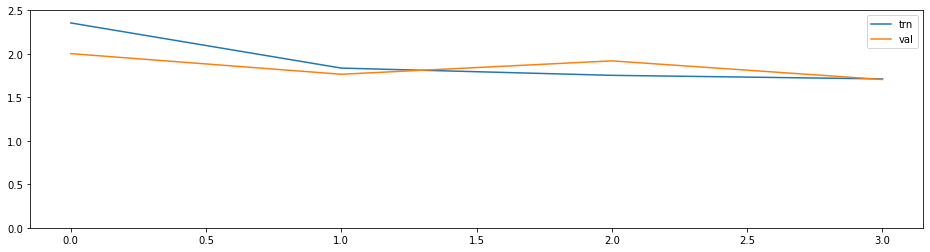

 epoch: 2/3  246.61s loss: trn=1.7121 val=1.7051   perpl:  5.54   acc: trn=0.4958 val=0.4944
v:1.0350 g:0.0000   emb.weight           :    350  shape: (35, 10) 
v:0.4388 g:0.0000   rnn.rnn.weight_ih_l0 :   7500  shape: (750, 10) 
v:0.1397 g:0.0000   rnn.rnn.weight_hh_l0 : 187500  shape: (750, 250) 
v:0.2872 g:0.0000   rnn.rnn.bias_ih_l0   :    750  shape: (750,) 
v:0.2143 g:0.0000   rnn.rnn.bias_hh_l0   :    750  shape: (750,) 
v:0.2661 g:0.0000   fc.weight            :   8750  shape: (35, 250) 
v:0.5275 g:0.0000   fc.bias              :     35  shape: (35,) 
 trn 222.9s 992:43%  loss: 1.6882 acc: 0.4996

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

model.rnn.mode = 1

epochs =200                                               # число эпох
for epoch in range(epochs):                              # эпоха - проход по всем примерам
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    optimizer = torch.optim.SGD(model.parameters(),  lr=1, momentum=0.8)
    
    beg = tm()
    
    idx = torch.randperm( len(X_trn) )     # перемешанный список индексов
    X_trn = X_trn[idx]
    Y_trn = Y_trn[idx]
    
    L_trn, A_trn = fit(model, X_trn, Y_trn, batch_size=256, NUM = NUM, train=True )      
    L_val, A_val = fit(model, X_val, Y_val, batch_size=256, NUM = 1,  train=False) 
    losses.append([L_trn, L_val])
                
    if epoch % 1 == 0 or it == epochs-1:     
        clear_output(wait=True)

        plt.figure(figsize=(16,4)); plt.plot(losses);  plt.ylim(0, 2.5);   plt.legend(['trn', 'val']);  plt.show()
        
        if model.rnn.mode != 1:
            fig, ax1 = plt.subplots()
            fig.set_size_inches(16,4)
            ax2 = ax1.twinx() 
            ax1.set_ylabel(r'$g^{(h)}$', color='b', fontsize=18); ax2.set_ylabel('h', color='g', fontsize=18)
            ax2.plot(model.rnn.V_h.numpy()[1:], marker='.', linestyle='--', color="green");  ax2.set_ylim(0, None)
            ax1.plot(model.rnn.G_h.numpy()[1:], marker='o', linewidth = 3,    color="blue");   ax1.set_ylim(0, None); 
            ax1.plot(model.rnn.G_y.numpy(), marker='.',                 color="blue");   ax1.set_ylim(0, None);         
            plt.show(); 
                           
        print('\r', f'epoch: {epoch:d}/{len(losses)-1}  {tm()-beg:.2f}s loss: trn={L_trn:.4f} val={L_val:.4f}  ',   
              f'perpl: {np.exp(L_trn):5.2f}   acc: trn={A_trn:.4f} val={A_val:.4f}' )  
              #f'acc: {A:.4f} {(oks*tot).sum():.4f}  {oks.mean():.4f} {len(oks[oks > 1/len(oks)])/len(oks):.2f}' )  
        
        params_stat(model)
            
        #for i,c in enumerate(CHARS):
        #    print(f"{c}: {oks[i]:.3f}; {tot[i]:.3f}")        

# Результаты
```
                    mode=1            mode=2                  mode=3
26s  -> 29.16      25.5  _> 28.82    29.2 -> 33.24            53.3  -> 57.6
24.7s -> 27.86     25,      28.7     28.5 -> 32.51 
25.   -> 28.28                       28.6 -> 32.31
```

```
LENGTH, STEP = 100, 1
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0.2
epoch: 19/19  63.26s loss: trn=1.5113 val=1.3357   (last: 1.5091)  perpl:  4.53 acc: 0.5208 0.5208  0.5094 1.00

LENGTH, STEP = 100, 1
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  GRU
epoch: 19/19  55.01s loss: trn=0.9968 val=0.9993   perpl:  2.71   acc: trn=0.7358 val=0.7358
epoch: 52/125 55.95s loss: trn=0.1353 val=0.1353   perpl:  1.14   acc: trn=0.9743 val=0.9743

LENGTH, STEP = 100, 1 
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  LSTM
epoch: 21/21  56.09s loss: trn=1.2782 val=1.2694   perpl:  3.59   acc: trn=0.6559 val=0.6559
epoch: 40/62  57.16s loss: trn=0.4476 val=0.4318   perpl:  1.56   acc: trn=0.8810 val=0.8810
epoch: 63/126 57.46s loss: trn=0.1022 val=0.0880   perpl:  1.11   acc: trn=0.9828 val=0.9828

LENGTH, STEP = 100, 1 
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  GRU NUM = 90
epoch: 25/25  35.94s loss: trn=0.6280 val=0.5689   perpl:  1.87   acc: trn=0.8474 val=0.8474
epoch: 32/58  37.74s loss: trn=0.2546 val=0.1764   perpl:  1.29   acc: trn=0.9609 val=0.9609
epoch: 70/129 37.24s loss: trn=0.0953 val=0.0427   perpl:  1.10   acc: trn=0.9934 val=0.9934
epoch: 0/156  37.74s loss: trn=0.0746 val=0.0319   perpl:  1.08   acc: trn=0.9947 val=0.9956

```


# Генерация текста

In [ ]:
import numpy as np

st = "три девицы под окном пряли "
#st = "кабы я была"
#st = "говорит одна"
#st = "то на весь крещ"
#st = "уложили спать"

model.rnn.mode = 1
def random_char(probs):        
    return np.random.choice(len(probs), 1, p=probs)[0]

x = torch.tensor( [ charID[ st[0] ]  ], dtype=torch.long).view(1,1)
h = torch.zeros (NUM_LAYERS, 1, H_DIM) 
for i in range(1000):
    y, h = model(x, h0 = h.detach(), NUM=1)                   # (B,C,1), (LAYERS,B,H)  
    probs = nn.Softmax(dim=1)(y.detach()[:,:,-1])
    probs = probs.to(cpu).numpy().reshape(-1)    
    idx = charID[ st[i] ] if i < len(st) else random_char(probs)         
    x[0,0]  = torch.tensor(idx, dtype=torch.long, device=gpu) 
    print(CHARS[idx], end="")            

# Cохранение модели

In [ ]:
import datetime
  
state = {'info':      "RNN генератор текста по буквам",   
         'date':      datetime.datetime.now(),            
         'parms':     "",            
         'model' :    model.state_dict(),                 
         'optimizer': optimizer.state_dict()}             
 
torch.save(state, 'rnn_char_100_10_100_1_loss_0_xx.pt')                          

In [ ]:
state = torch.load('rnn_char_100_10_100_1_loss_0_xx.pt')                   # загружаем файл
 
model.load_state_dict(state['model'])        # получаем параметры модели

# Tests

In [ ]:
tm1 = tm()

y = torch.empty(100,256,256)        
for i in range(100):
    x = torch.randn(256,256, 
                    requires_grad=True)
    y[i] = x
    
y.retain_grad()   
z = y.sum()
z.backward()
    
print(tm()-tm1   )
print(y.grad_fn, y.grad.shape)

In [ ]:
tm1 = tm()

y = []       
for i in range(100):
    x = torch.randn(1,256,256, requires_grad=True)
    y.append( x )        
y = torch.cat(y, dim=0)

#x.retain_grad()   
z = y.sum()
z.backward()
  
print(tm()-tm1)
print(y.grad_fn)

In [ ]:
import torchviz
from torch import tensor, empty, ones, zeros

x, w, b = ones(5), ones(5, requires_grad=True), tensor(0., requires_grad=True)
z = x.dot(w) + b

torchviz.make_dot(z,  params = {'x': x, 'w': w, 'b': b} )

In [ ]:
idx = torch.tensor([1,0,2,0])
torch.zeros(len(idx),3).scatter_(1, idx.unsqueeze(1), 1.)

In [ ]:
L, C = 3, 4

inp = torch.tensor([ [1,0,1],  [0,2,3] ], dtype=torch.long)
one_hot = torch.zeros(len(inp), L, C).scatter_(2, inp.unsqueeze(2),  1.)
print(one_hot)